### No Penalty For Adding More Bbox

If you add new bbox with confidence score less than the lowest confidence score for all of that class in your entire CSV file, then your CV LB can only increase, it cannot decrease!

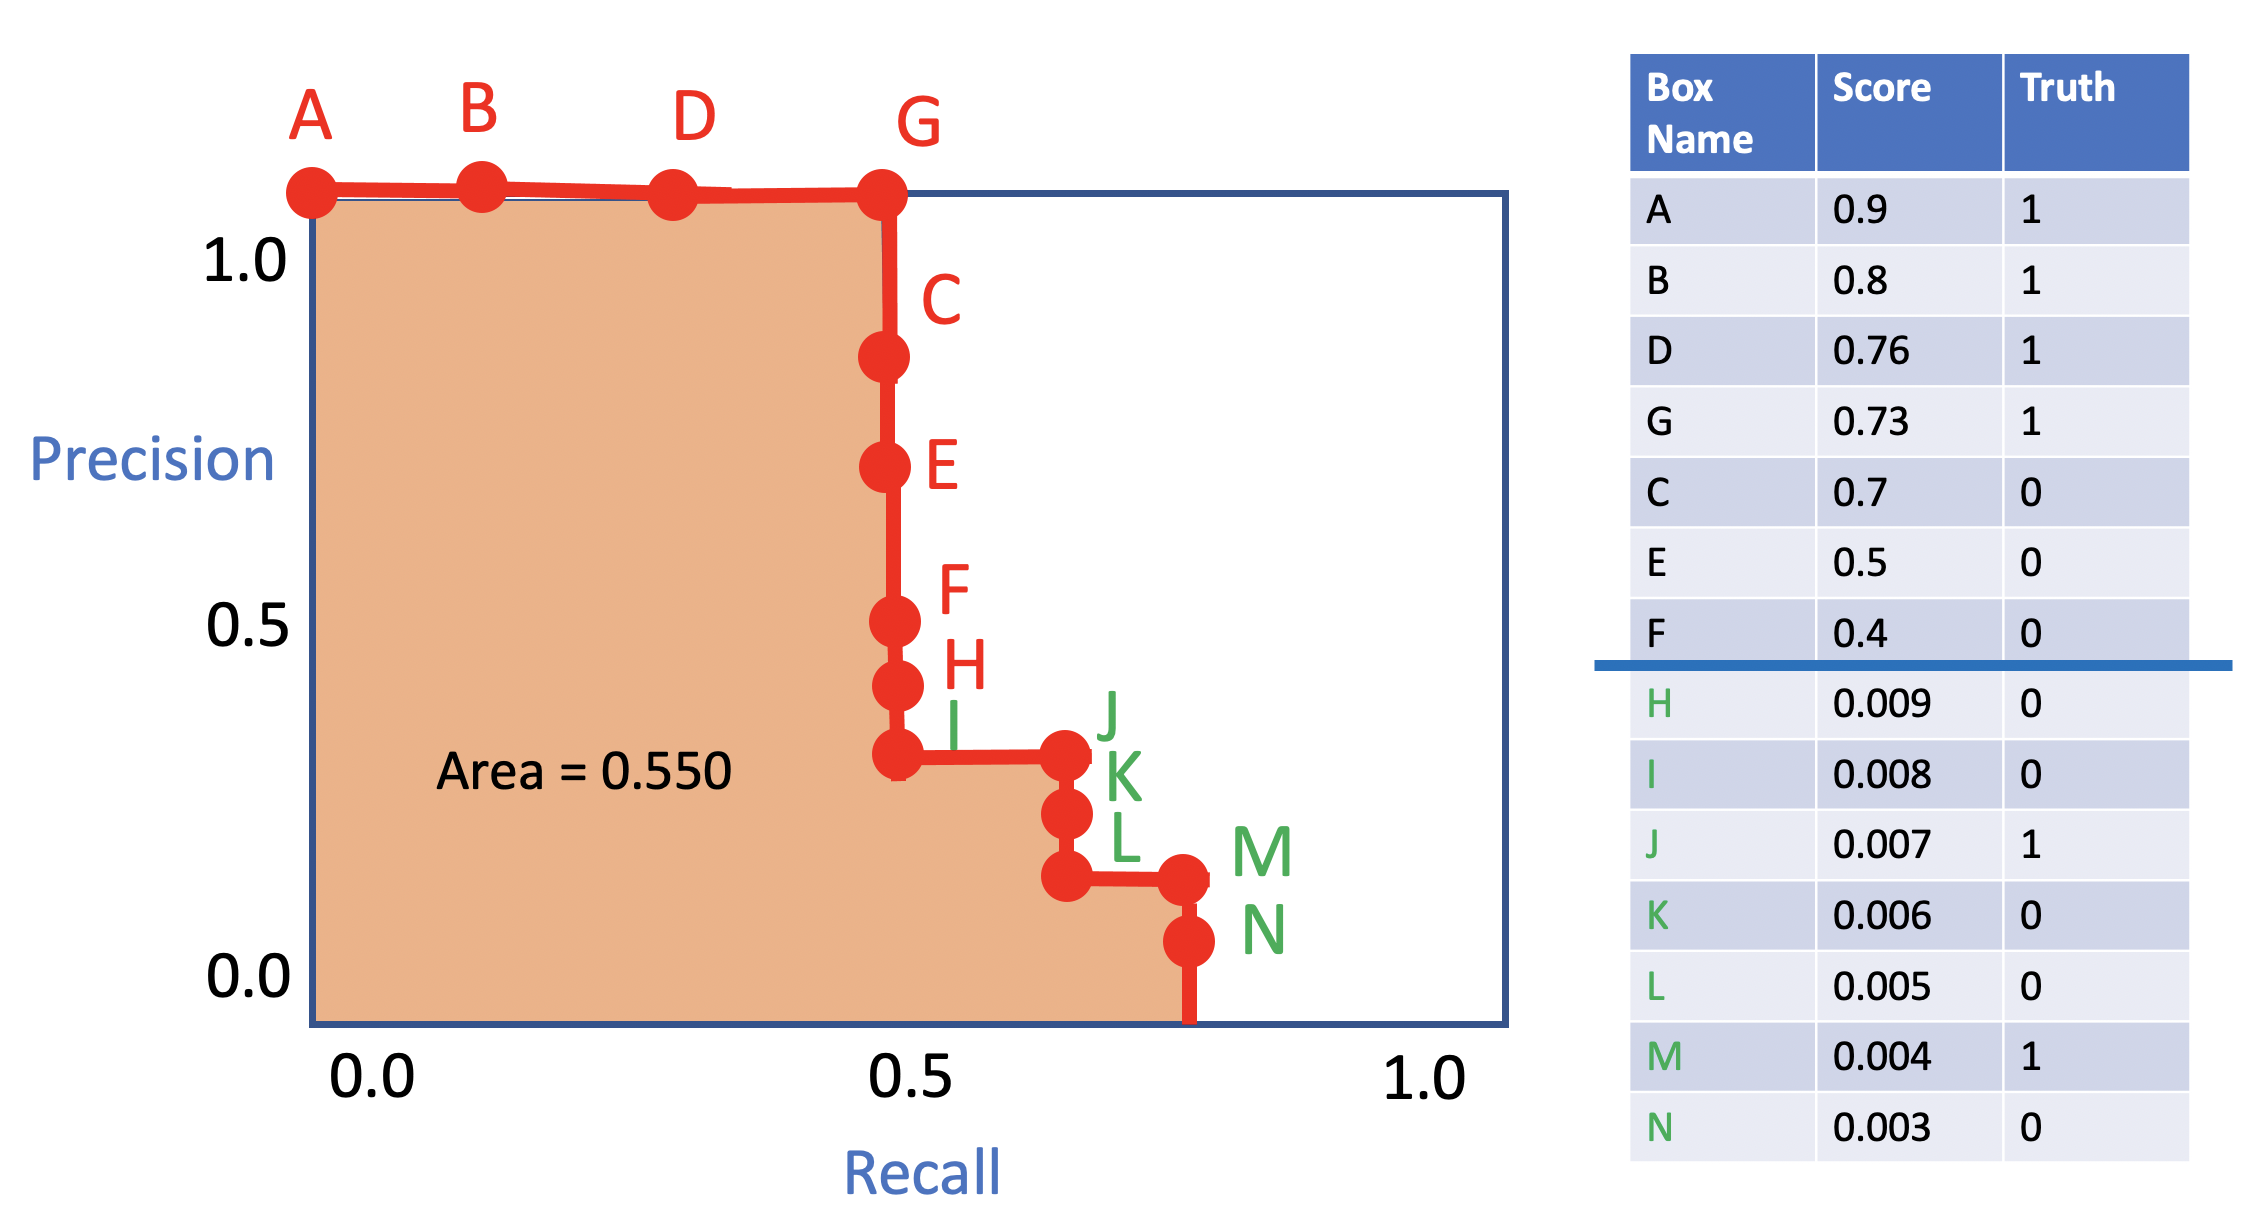

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
!pip install -q map-boxes

In [42]:
from map_boxes import get_real_annotations
from map_boxes import get_detections
from map_boxes import _compute_ap
from map_boxes import compute_overlap

In [54]:
def mean_average_precision_for_boxes(ann, pred, iou_threshold=0.5, exclude_not_in_annotations=False, verbose=True):
    """

    :param ann: path to CSV-file with annotations or numpy array of shape (N, 6)
    :param pred: path to CSV-file with predictions (detections) or numpy array of shape (N, 7)
    :param iou_threshold: IoU between boxes which count as 'match'. Default: 0.5
    :param exclude_not_in_annotations: exclude image IDs which are not exist in annotations. Default: False
    :param verbose: print detailed run info. Default: True
    :return: tuple, where first value is mAP and second values is dict with AP for each class.
    """

    if isinstance(ann, str):
        valid = pd.read_csv(ann)
    else:
        valid = pd.DataFrame(ann, columns=['ImageID', 'LabelName', 'XMin', 'XMax', 'YMin', 'YMax'])

    if isinstance(pred, str):
        preds = pd.read_csv(pred)
    else:
        preds = pd.DataFrame(pred, columns=['ImageID', 'LabelName', 'Conf', 'XMin', 'XMax', 'YMin', 'YMax'])

    ann_unique = valid['ImageID'].unique().astype(str)
    preds_unique = preds['ImageID'].unique().astype(str)

    if verbose:
        print('Number of files in annotations: {}'.format(len(ann_unique)))
        print('Number of files in predictions: {}'.format(len(preds_unique)))

    # Exclude files not in annotations!
    if exclude_not_in_annotations:
        preds = preds[preds['ImageID'].isin(ann_unique)]
        preds_unique = preds['ImageID'].unique()
        if verbose:
            print('Number of files in detection after reduction: {}'.format(len(preds_unique)))

    unique_classes = valid['LabelName'].unique().astype(str)
    if verbose:
        print('Unique classes: {}'.format(len(unique_classes)))

    all_detections = get_detections(preds)
    all_annotations = get_real_annotations(valid)
    if verbose:
        print('Detections length: {}'.format(len(all_detections)))
        print('Annotations length: {}'.format(len(all_annotations)))

    average_precisions = {}
    for zz, label in enumerate(sorted(unique_classes)):

        # Negative class
        if str(label) == 'nan':
            continue

        false_positives = []
        true_positives = []
        scores = []
        num_annotations = 0.0

        for i in range(len(ann_unique)):
            detections = []
            annotations = []
            id = ann_unique[i]
            if id in all_detections:
                if label in all_detections[id]:
                    detections = all_detections[id][label]
            if id in all_annotations:
                if label in all_annotations[id]:
                    annotations = all_annotations[id][label]

            if len(detections) == 0 and len(annotations) == 0:
                continue

            num_annotations += len(annotations)
            detected_annotations = []

            annotations = np.array(annotations, dtype=np.float64)
            for d in detections:
                scores.append(d[4])

                if len(annotations) == 0:
                    false_positives.append(1)
                    true_positives.append(0)
                    continue

                overlaps = compute_overlap(np.expand_dims(np.array(d, dtype=np.float64), axis=0), annotations)
                assigned_annotation = np.argmax(overlaps, axis=1)
                max_overlap = overlaps[0, assigned_annotation]

                if max_overlap >= iou_threshold and assigned_annotation not in detected_annotations:
                    false_positives.append(0)
                    true_positives.append(1)
                    detected_annotations.append(assigned_annotation)
                else:
                    false_positives.append(1)
                    true_positives.append(0)

        if num_annotations == 0:
            average_precisions[label] = 0, 0
            continue

        false_positives = np.array(false_positives)
        true_positives = np.array(true_positives)
        scores = np.array(scores)

        # sort by score
        indices = np.argsort(-scores)
        false_positives = false_positives[indices]
        true_positives = true_positives[indices]

        # compute false positives and true positives
        false_positives = np.cumsum(false_positives)
        true_positives = np.cumsum(true_positives)

        # compute recall and precision
        recall = true_positives / num_annotations
        precision = true_positives / np.maximum(true_positives + false_positives, np.finfo(np.float64).eps)

        # compute average precision
        average_precision = _compute_ap(recall, precision)
        average_precisions[label] = average_precision, num_annotations, precision, recall
        if verbose:
            s1 = "{:30s} | {:.6f} | {:7d}".format(label, average_precision, int(num_annotations))
            print(s1)

    present_classes = 0
    precision = 0
    for label, (average_precision, num_annotations, _, _) in average_precisions.items():
        if num_annotations > 0:
           present_classes += 1
           precision += average_precision
    mean_ap = precision / present_classes
    if verbose:
        print('mAP: {:.6f}'.format(mean_ap))
    return mean_ap, average_precisions

In [55]:
ann = pd.read_csv('/content/annotations.csv')
det = pd.read_csv('/content/detections.csv')

In [56]:
det_conf_05 = det[det['Conf'] >= 0.5]
det_conf_04 = det[det['Conf'] >= 0.4]
det_conf_03 = det[det['Conf'] >= 0.3]
det_conf_02 = det[det['Conf'] >= 0.2]
det_conf_01 = det[det['Conf'] >= 0.1]
det_conf_005 = det[det['Conf'] >= 0.05]
det_conf_001 = det[det['Conf'] >= 0.01]

In [57]:
mean_ap_conf_05, average_precisions_conf_05 = mean_average_precision_for_boxes(ann,det_conf_05, iou_threshold=0.5, verbose=False)
mean_ap_conf_04, average_precisions_conf_04 = mean_average_precision_for_boxes(ann,det_conf_04, iou_threshold=0.5, verbose=False)
mean_ap_conf_03, average_precisions_conf_03 = mean_average_precision_for_boxes(ann,det_conf_03, iou_threshold=0.5, verbose=False)
mean_ap_conf_02, average_precisions_conf_02 = mean_average_precision_for_boxes(ann,det_conf_02, iou_threshold=0.5, verbose=False)
mean_ap_conf_01, average_precisions_conf_01 = mean_average_precision_for_boxes(ann,det_conf_01, iou_threshold=0.5, verbose=False)
mean_ap_conf_005, average_precisions_conf_005 = mean_average_precision_for_boxes(ann,det_conf_005, iou_threshold=0.5, verbose=False)
mean_ap_conf_001, average_precisions_conf_001 = mean_average_precision_for_boxes(ann,det_conf_001, iou_threshold=0.5, verbose=False)

In [58]:
print('mAP with Conf Threshold 0.5', round(mean_ap_conf_05, 4))
print('mAP with Conf Threshold 0.4', round(mean_ap_conf_04, 4))
print('mAP with Conf Threshold 0.3', round(mean_ap_conf_03, 4))
print('mAP with Conf Threshold 0.2', round(mean_ap_conf_02, 4))
print('mAP with Conf Threshold 0.1', round(mean_ap_conf_01, 4))
print('mAP with Conf Threshold 0.05', round(mean_ap_conf_005, 4))
print('mAP with Conf Threshold 0.01', round(mean_ap_conf_001, 4))

mAP with Conf Threshold 0.5 0.3887
mAP with Conf Threshold 0.4 0.4184
mAP with Conf Threshold 0.3 0.4469
mAP with Conf Threshold 0.2 0.4714
mAP with Conf Threshold 0.1 0.4934
mAP with Conf Threshold 0.05 0.4934
mAP with Conf Threshold 0.01 0.4934


In [70]:
label_index =ann['LabelName'].unique()

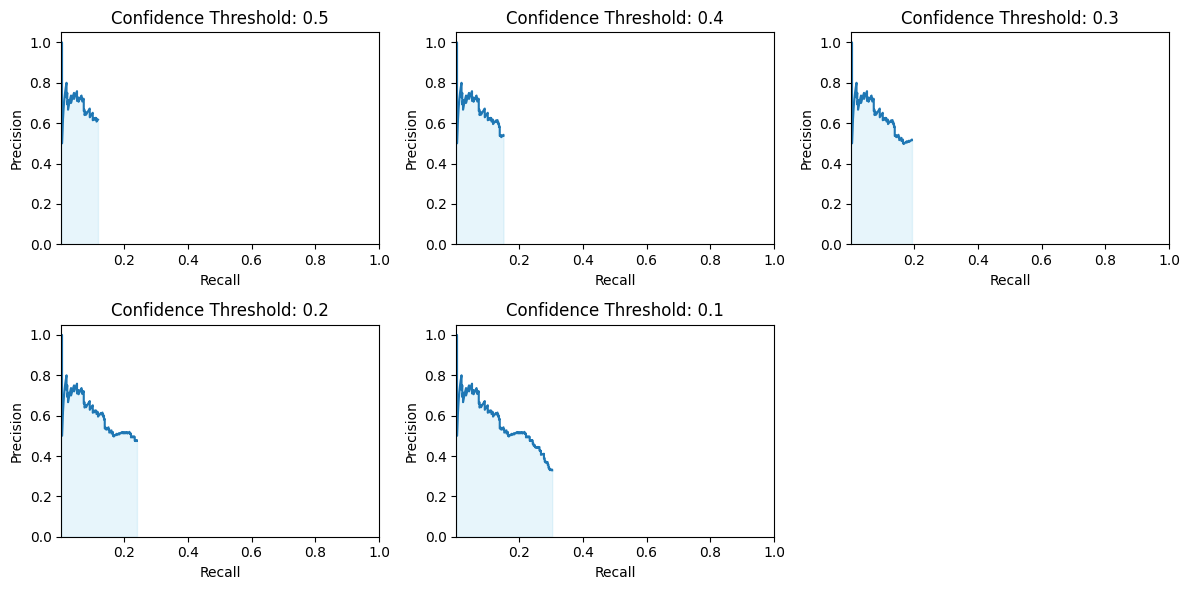

In [86]:
_, _, precision_05, recall_05 = average_precisions_conf_05[label_index[5]]
_, _, precision_04, recall_04 = average_precisions_conf_04[label_index[5]]
_, _, precision_03, recall_03 = average_precisions_conf_03[label_index[5]]
_, _, precision_02, recall_02 = average_precisions_conf_02[label_index[5]]
_, _, precision_01, recall_01 = average_precisions_conf_01[label_index[5]]


plt.figure(figsize=(12,6))

plt.subplot(2,3,1)
plt.plot(recall_05, precision_05)
plt.fill_between(recall_05, precision_05, color='skyblue', alpha=0.2)
plt.title('Confidence Threshold: 0.5')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.xlim([recall_05.min(), 1.0])
plt.ylim([0.0, 1.05])

plt.subplot(2,3,2)
plt.plot(recall_04, precision_04)
plt.fill_between(recall_04, precision_04, color='skyblue', alpha=0.2)
plt.title('Confidence Threshold: 0.4')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.xlim([recall_04.min(), 1.0])
plt.ylim([0.0, 1.05])

plt.subplot(2,3,3)
plt.plot(recall_03, precision_03)
plt.fill_between(recall_03, precision_03, color='skyblue', alpha=0.2)
plt.title('Confidence Threshold: 0.3')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.xlim([recall_03.min(), 1.0])
plt.ylim([0.0, 1.05])

plt.subplot(2,3,4)
plt.plot(recall_02, precision_02)
plt.fill_between(recall_02, precision_02, color='skyblue', alpha=0.2)
plt.title('Confidence Threshold: 0.2')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.xlim([recall_02.min(), 1.0])
plt.ylim([0.0, 1.05])

plt.subplot(2,3,5)
plt.plot(recall_01, precision_01)
plt.fill_between(recall_01, precision_01, color='skyblue', alpha=0.2)
plt.title('Confidence Threshold: 0.1')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.xlim([recall_01.min(), 1.0])
plt.ylim([0.0, 1.05])

plt.tight_layout()
plt.show()

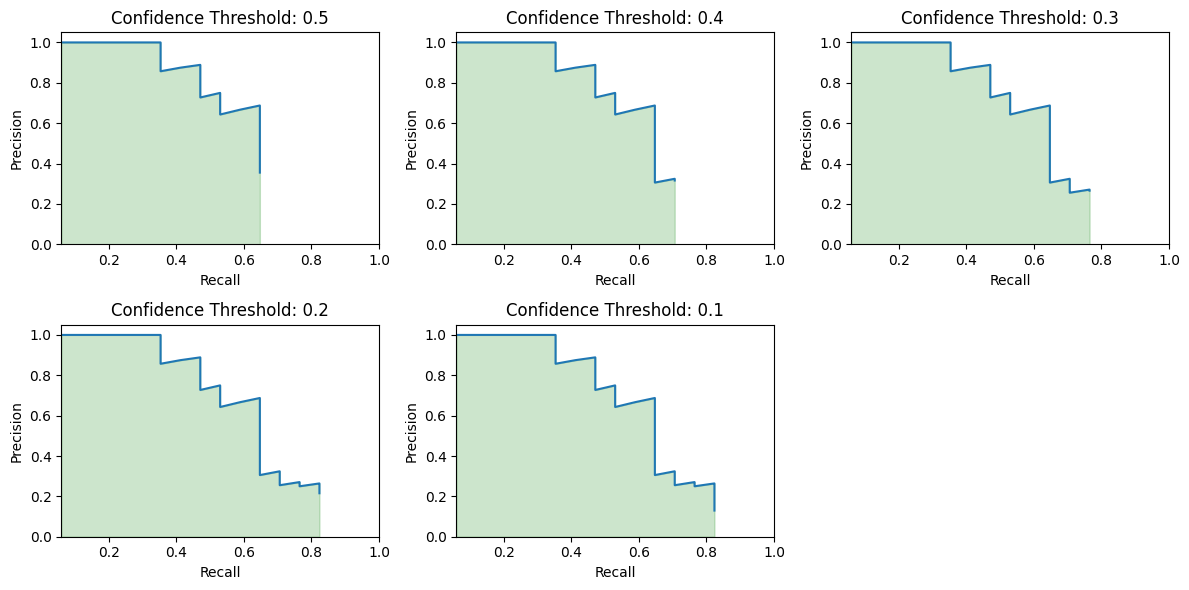

In [89]:
_, _, precision_05, recall_05 = average_precisions_conf_05[label_index[15]]
_, _, precision_04, recall_04 = average_precisions_conf_04[label_index[15]]
_, _, precision_03, recall_03 = average_precisions_conf_03[label_index[15]]
_, _, precision_02, recall_02 = average_precisions_conf_02[label_index[15]]
_, _, precision_01, recall_01 = average_precisions_conf_01[label_index[15]]


plt.figure(figsize=(12,6))

plt.subplot(2,3,1)
plt.plot(recall_05, precision_05)
plt.fill_between(recall_05, precision_05, color='green', alpha=0.2)
plt.title('Confidence Threshold: 0.5')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.xlim([recall_05.min(), 1.0])
plt.ylim([0.0, 1.05])

plt.subplot(2,3,2)
plt.plot(recall_04, precision_04)
plt.fill_between(recall_04, precision_04, color='green', alpha=0.2)
plt.title('Confidence Threshold: 0.4')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.xlim([recall_04.min(), 1.0])
plt.ylim([0.0, 1.05])

plt.subplot(2,3,3)
plt.plot(recall_03, precision_03)
plt.fill_between(recall_03, precision_03, color='green', alpha=0.2)
plt.title('Confidence Threshold: 0.3')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.xlim([recall_03.min(), 1.0])
plt.ylim([0.0, 1.05])

plt.subplot(2,3,4)
plt.plot(recall_02, precision_02)
plt.fill_between(recall_02, precision_02, color='green', alpha=0.2)
plt.title('Confidence Threshold: 0.2')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.xlim([recall_02.min(), 1.0])
plt.ylim([0.0, 1.05])

plt.subplot(2,3,5)
plt.plot(recall_01, precision_01)
plt.fill_between(recall_01, precision_01, color='green', alpha=0.2)
plt.title('Confidence Threshold: 0.1')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.xlim([recall_01.min(), 1.0])
plt.ylim([0.0, 1.05])

plt.tight_layout()
plt.show()